In [85]:
import matplotlib.pyplot as plt
import neurokit2 as nk
from tqdm import tqdm
import pandas as pd
import numpy as np
import h5py

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

In [86]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size

        # Энкодер
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,  # hidden_size энкодера
            num_layers=num_layers,
            batch_first=True
        )

        # Декодер
        self.decoder = nn.LSTM(
            input_size=input_size,  # Вход декодера имеет размер input_size
            hidden_size=hidden_size,  # hidden_size декодера
            num_layers=num_layers,
            batch_first=True
        )

        # Полносвязный слой для преобразования выхода декодера
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # Инициализация скрытого состояния и состояния ячейки
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Энкодер
        _, (hidden, cell) = self.encoder(x, (h0, c0))

        # Декодер
        # Инициализируем вход декодера нулями
        decoder_input = torch.zeros(x.size(0), x.size(1), self.input_size).to(x.device)
        
        # Передаем скрытое состояние и состояние ячейки от энкодера
        output, _ = self.decoder(decoder_input, (hidden, cell))

        # Преобразуем выход декодера к размеру input_size
        output = self.fc(output)

        return output

In [141]:
# device = "cuda"
device = "cpu"

def load_data_kaggle(metadata_filepath, sample_freq, N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv('/kaggle/input/metadata/metadata.csv')
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)


    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])
     
        # Считываем файл.
        with h5py.File(f'/kaggle/input/ecgdata/records/{i}.h5', 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")
    return signals, labels

def load_data(metadata_filepath, sample_freq, N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv('metadata.csv')
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)


    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        with h5py.File(f'records/record{record_num}/{i}.h5', 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels

def signal_transform_tensor_12(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    results_reshape = []

    scaler = MinMaxScaler()
    for i in range(12):
        # results_reshape.append(np.reshape([nk.ecg_clean(signal[i][0:max_len_signal], sampling_rate=sampling_rate) for signal in signals], (1, max_len_signal * len(signals))))
        results_reshape.append(np.reshape([signal[i][0:max_len_signal] for signal in signals], (1, max_len_signal * len(signals))))

    result_reshape = np.concatenate(results_reshape)

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((12, len(signals), max_len_signal)).permute((1,2,0))

def signal_transform_tensor_12_scaled(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    results_reshape = []

    scaler = MinMaxScaler()
    for i in range(12):
        # results_reshape.append(np.reshape([nk.ecg_clean(signal[i][0:max_len_signal], sampling_rate=sampling_rate) for signal in signals], (1, max_len_signal * len(signals))))
        s = [scaler.fit_transform(signal[i][0:max_len_signal].reshape(-1, 1)).reshape(max_len_signal) for signal in signals]
        
        results_reshape.append(np.reshape(s, (1, max_len_signal * len(signals))))

    result_reshape = np.concatenate(results_reshape)

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((12, len(signals), max_len_signal)).permute((1,2,0))

def label_transform_tensor(labels, all_diagnoses=False):
    """Транформирует лейблы в тензор.\n
    Сейчас только в режиме 'Норма-Не норма'."""

    # TODO: сделать разбиение лейблов на первичное и вторичное заключение врача

    result_labels = []

    if all_diagnoses:
        return None
    
    else:
        # Норма - Не норма
        for label in labels:
            if label == '1':
                result_labels.append(0)
            else:
                result_labels.append(1)

    result_labels = torch.tensor(result_labels, dtype=torch.float32).reshape((len(result_labels), 1))

    print("Label transformed to tensor successfully\n")

    return result_labels

def pipeline_1_model_iteration(N, save_weights_name, num_epochs=10, lr=0.01, momentum=0.9, weight_decay=0.0001, plot=False):
    metadata_filepath = 'metadata.csv'
    sample_freq = 500

    # Загружаем данные
    signals, labels = load_data(metadata_filepath, sample_freq, N_end=N, only_health=True)

    # Трансформируем данные для обучения
    signals_12_transformed = signal_transform_tensor_12(signals, max_len_signal=5000)

    labels_transformed = label_transform_tensor(labels)

    # Разделение данных на вход (X) и метки (y)
    X = signals_12_transformed.to(device)  # (batch_size, seq_len, input_size)
    y = labels_transformed.to(device)

    # Создание TensorDataset
    dataset = TensorDataset(X, y)

    # Разделение на обучающую и тестовую выборки
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Создание DataLoader
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Параметры модели
    input_size = 12
    hidden_size = 64
    num_layers = 2

    model_0 = LSTMAutoencoder(input_size, hidden_size, num_layers)

    print("Model initialized\n")

    # # Определение функции потерь и оптимизатора
    # criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    # # optimizer = torch.optim.Adam(model_0.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = torch.optim.SGD(model_0.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    criterion = nn.MSELoss()  # Среднеквадратичная ошибка

    optimizer = torch.optim.SGD(model_0.parameters(), lr=lr, weight_decay=weight_decay)

    print("Model training...\n")
    # Обучение модели
    for epoch in range(num_epochs):
        model_0.train()

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
        for batch_x, batch_y in progress_bar:
            optimizer.zero_grad()
            # outputs = model_0(batch_x)
            # loss = criterion(outputs, batch_y)
            # loss.backward()
            # optimizer.step()

            # Forward pass
            reconstructed_data = model_0(batch_x)

            # Вычисление ошибки восстановления
            loss = criterion(reconstructed_data, batch_x)

            loss.backward()
            optimizer.step()
            
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}"
            })

    # # Оценка модели
    # model_0.eval()
    # correct = 0
    # total = 0

    # if plot:
    #     plt.figure(figsize=(10, 6))

    # with torch.no_grad():
    #     for batch_X, batch_y in test_loader:
    #         outputs = model_0(batch_X)
    #         predicted = (outputs > 0.5).float()
    #         total += batch_y.size(0)
    #         correct += (predicted == batch_y).sum().item()

    #         if plot:
    #             plt.plot(batch_y.tolist(), label='True Labels', marker='o', linestyle='None')
    #             plt.plot(predicted.tolist(), label='Predicted Labels', marker='x', linestyle='None')

    # accuracy = correct / total
    # print(f'Test Accuracy: {accuracy:.4f}')

    # # Визуализация результатов
    # if plot:
    #     plt.legend()
    #     plt.show()

    torch.save(model_0.state_dict(), save_weights_name)

    return model_0

# if __name__=='__main__':
#     save_path = './weights/0/12_2048_SGD_10_0.0001_0.9_0.pth'

#     pipeline_0_model_iteration(64, save_path, _channel=0, lr=0.0001, momentum=0.9, plot=False)

In [142]:
# import gc

save_path = './weights/encoder_12_2048_SGD_10_0.0001_0.9_0.pth'

# gc.collect()

model = pipeline_1_model_iteration(128, num_epochs=5, save_weights_name=save_path, lr=0.01, momentum=0.9, plot=True)

# torch.cuda.empty_cache()

Data loaded successfully.
          Health    number:     75
          Diseased  number:     0


Label transformed to tensor successfully

Model initialized

Model training...



Epoch 5/5: 100%|██████████| 2/2 [00:10<00:00,  5.25s/batch, Loss=0.0370]


In [143]:
model.eval()

def compute_reconstruction_error(model, data):
    with torch.no_grad():
        reconstructed_data = model(data)
        error = torch.mean((reconstructed_data - data) ** 2, dim=(1, 2))  # MSE по последовательности
    return error

# # Вычисляем ошибки для нормальных и аномальных данных
# normal_errors = compute_reconstruction_error(model, test_normal_data)
# anomalous_errors = compute_reconstruction_error(model, test_anomalous_data)

# print("Ошибки для нормальных данных:", normal_errors)
# print("Ошибки для аномальных данных:", anomalous_errors)

In [144]:
def data_loader(N):
    metadata_filepath = 'metadata.csv'
    sample_freq = 500

    # Загружаем данные
    signals, labels = load_data(metadata_filepath, sample_freq, N_end=N)

    # Трансформируем данные для обучения
    signals_12_transformed = signal_transform_tensor_12(signals, max_len_signal=5000)

    labels_transformed = label_transform_tensor(labels)

    # Разделение данных на вход (X) и метки (y)
    X = signals_12_transformed.to(device)  # (batch_size, seq_len, input_size)
    y = labels_transformed.to(device)

    # Создание TensorDataset
    dataset = TensorDataset(X, y)

    return dataset

In [145]:
data_loader200 = data_loader(200)

Data loaded successfully.
          Health    number:     108
          Diseased  number:     92


Label transformed to tensor successfully



In [146]:
normal_errors = []
abnormal_errors = []

for batch_x, batch_y in data_loader200:
    if batch_y[0] == 0:
        normal_errors.append(compute_reconstruction_error(model, batch_x.reshape(1,5000,12)))
    else:
        abnormal_errors.append(compute_reconstruction_error(model, batch_x.reshape(1,5000,12)))

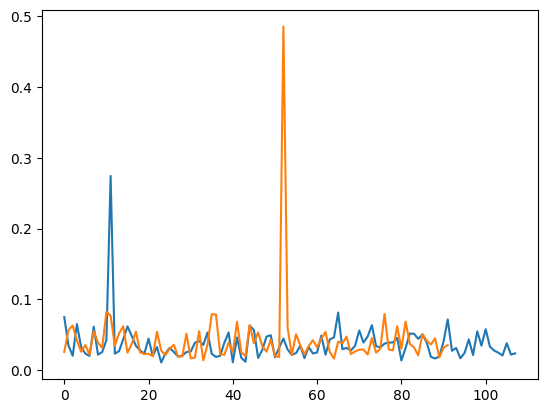

In [ ]:
# Без фильтрации nerokit

plt.plot([normal_error[0] for normal_error in normal_errors])
plt.plot([abnormal_error[0] for abnormal_error in abnormal_errors])

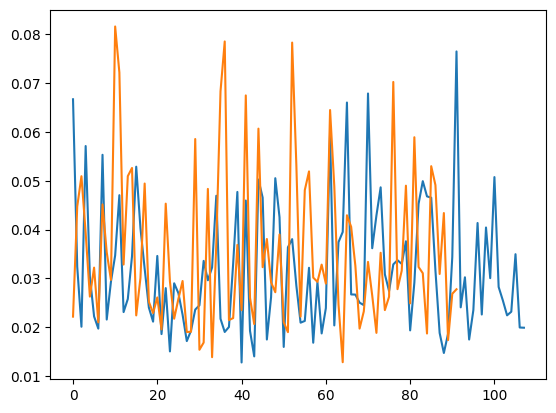

In [ ]:
# С фильтрацией nerokit

plt.plot([normal_error[0] for normal_error in normal_errors])
plt.plot([abnormal_error[0] for abnormal_error in abnormal_errors])

In [ ]:
# Параметры модели
input_size = 10  # Размерность входных данных
hidden_size = 64  # Размер скрытого состояния
num_layers = 2  # Количество слоев LSTM

# Создаем модель
model = LSTMAutoencoder(input_size, hidden_size, num_layers)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()  # Среднеквадратичная ошибка
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Генерация случайных данных (нормальные данные)
# batch_size = 32, sequence_length = 100, input_size = 10
normal_data = torch.randn(32, 100, 10)

# Цикл обучения
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    reconstructed_data = model(normal_data)

    # Вычисление ошибки восстановления
    loss = criterion(reconstructed_data, normal_data)

    # Backward pass и оптимизация
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/10, Loss: 1.0069342851638794
Epoch 2/10, Loss: 1.0054664611816406
Epoch 3/10, Loss: 1.0041805505752563
Epoch 4/10, Loss: 1.0030447244644165
Epoch 5/10, Loss: 1.0020394325256348
Epoch 6/10, Loss: 1.0011546611785889
Epoch 7/10, Loss: 1.0003873109817505
Epoch 8/10, Loss: 0.9997419714927673
Epoch 9/10, Loss: 0.9992290139198303
Epoch 10/10, Loss: 0.9988618493080139
